In [1]:
import os
import tqdm
import torch
import torchvision
import torchsummary
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

### VAE model

In [2]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        # encoder
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, latent_dim)
        self.fc3 = nn.Linear(128, latent_dim)
        
        # decoder
        self.fc4 = nn.Linear(latent_dim, 128)
        self.fc5 = nn.Linear(128, 784)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, mu, log_var

### 2D latent space 變化圖 (20x20 Grids)

In [3]:
def plot_2d_latent_change(model, device, r0=(-5, 5), r1=(-5, 5), n=20):
    w = 28
    img = np.zeros((n*w, n*w))
    
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decode(z)
            x_hat = x_hat.reshape(28, 28).cpu().data.numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
   
    plt.imshow(img, extent=[*r0, *r1])
    plt.show()


### 2D Label 分佈

In [4]:
def plot_2d_label(model, dataloader, device):
    for i, (x, y) in enumerate(dataloader):
        x = x.view(-1, 28*28).to(device)
        mu, log_var = model.encode(x.to(device))
        z = model.reparameterize(mu.to(device), log_var.to(device))
        z = z.cpu().data.numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        
    plt.colorbar()
    plt.show()

### Training

In [5]:
def training(name, dataloader, latent_dim, device, learning_rate, epochs):
    model = VAE(latent_dim).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(f"Dataset: {name}, Latent Dimension: {latent_dim}")

    for epoch in range(epochs):
        for x, label in dataloader:
            x = x.view(-1, 28*28).to(device)
            batch_sz = x.size(0)
            recon_x, mu, log_var = model(x)
            
            # recon_loss = F.mse_loss(recon_x, x)
            recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / batch_sz
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / batch_sz
            
            loss = recon_loss + kl_div
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        # print Loss when training
        print(f"Epoch: [{epoch+1}/{epochs}], Loss: [{loss:.4f}], KL Div: [{kl_div:.4f}]")
        
      
    # print 16 images in 4x4 grids at last epoch of training
    img = recon_x.reshape(-1, 1, 28, 28) 
    img_grid = torchvision.utils.make_grid(img[:16], nrow=4, normalize=True)
    plt.imshow(img_grid.permute(1, 2, 0).cpu().data.numpy())
    plt.show()
        
    # Save model
    torch.save(model, f"VAE_{name}_{latent_dim}.pth")



### Testing

In [6]:
def testing(name, dataloader, latent_dim, device):
    model = torch.load(f"VAE_{name}_{latent_dim}.pth").to(device)
    model.eval()
    loss = 0
    
    print(f"Test Dataset: {name}, Latent Dimension: {latent_dim}")
    with torch.no_grad():
        for x, label in dataloader:
            x = x.view(-1, 28*28).to(device)
            batch_sz = x.size(0)
            recon_x, mu, log_var = model(x)
            
            recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') / batch_sz
            kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / batch_sz
            loss += recon_loss + kl_div
              
        print(f"Test Loss: [{loss/len(dataloader):.4f}]")
        img = recon_x.reshape(-1, 1, 28, 28)
        img_grid = torchvision.utils.make_grid(img[:16], nrow=4, normalize=True)
        plt.imshow(img_grid.permute(1, 2, 0).cpu().data.numpy())
        plt.show()
        if latent_dim == 2:
            plot_2d_latent_change(model, device)
            plot_2d_label(model, dataloader, device)

### Main Function

Testing... 
Test Dataset: MNIST, Latent Dimension: 32
Test Loss: [111.0801]


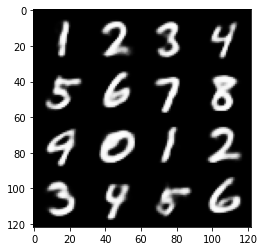

Test Dataset: MNIST, Latent Dimension: 2
Test Loss: [158.6690]


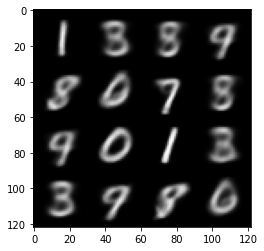

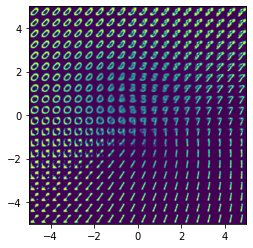

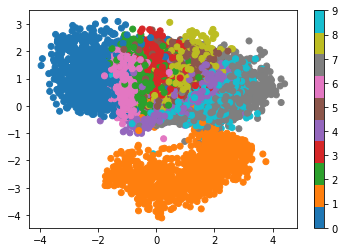

Test Dataset: FashionMNIST, Latent Dimension: 32
Test Loss: [247.7776]


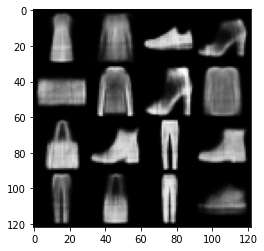

Test Dataset: FashionMNIST, Latent Dimension: 2
Test Loss: [266.8552]


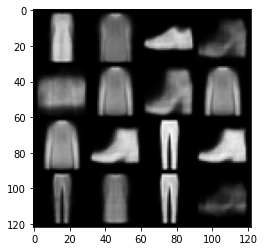

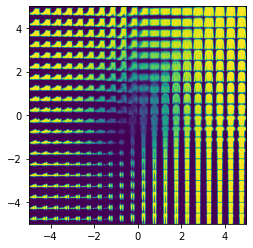

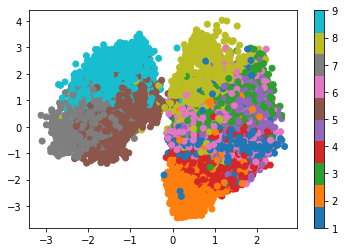

In [7]:
if __name__ == '__main__':
    # make two dir to save mnist and fashionmnit data
    os.makedirs("MNIST_dataset", exist_ok=True)
    os.makedirs("FashionMNIST_dataset", exist_ok=True)

    # dataset transform
    transform = transforms.Compose([
        # transforms.Resize((28, 28)), 
        transforms.ToTensor(), 
        # transforms.Normalize((0.5,), (0.5,))
    ])

    # download two train and two test dataset: 1. MNIST, 2. FashionMNIST
    MNIST_dataset = torchvision.datasets.MNIST(root="MNIST_dataset", transform=transform, download=True)
    FashionMNIST_dataset = torchvision.datasets.FashionMNIST(root="FashionMNIST_dataset", transform=transform, download=True)
    MNIST_test = torchvision.datasets.MNIST(root="MNIST_dataset", transform=transform, download=True, train=False)
    FashionMNIST_test = torchvision.datasets.FashionMNIST(root="FashionMNIST_dataset", transform=transform, download=True, train=False)
    
    # dataloader batch size
    batch_size = 128

    # dataset to DataLoader
    MNIST_dataloader = DataLoader(MNIST_dataset, batch_size, True)
    FashionMNIST_dataloader = DataLoader(FashionMNIST_dataset, batch_size, True)
    MNIST_testloader = DataLoader(MNIST_test, batch_size, False)
    FashionMNIST_testloader = DataLoader(FashionMNIST_test, batch_size, False)
    
    # using gpu
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # others hyperparameters
    epochs = 10
    learning_rate = 0.001

#     # Train
#     print("Training... ")
#     # MNIST for different latent
    latent_dims = [32, 2]
#     for latent_dim in latent_dims:
#         training("MNIST", MNIST_dataloader, latent_dim, 
#                 device, learning_rate, epochs)

#     # FashionMNIST for different latent
#     for latent_dim in latent_dims:
#         training("FashionMNIST", FashionMNIST_dataloader, latent_dim, 
#                 device, learning_rate, epochs)

    # Test
    print("Testing... ")
    # test DataLoader
    # MNIST for different latent
    for latent_dim in latent_dims:
        testing("MNIST", MNIST_testloader, latent_dim, device)

    # FashionMNIST for different latent
    for latent_dim in latent_dims:
        testing("FashionMNIST", FashionMNIST_testloader, latent_dim, device)
        
    